# Scalable Multitask GP Regression (w/ KISS-GP)

This notebook demonstrates how to perform a scalable multitask regression.

It does everything that the [standard multitask GP example](./Multitask_GP_Regression.ipynb) does, but using the SKI scalable GP approximation. This can be used on much larger datasets (up to 100,000+ data points).

For more information on SKI, check out the [scalable regression example](../04_Scalable_GP_Regression_1D/KISSGP_Regression_1D.ipynb).

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 1000 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 1000)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Set up the model

The model should be somewhat similar to the `ExactGP` model in the [simple regression example](../01_Simple_GP_Regression/Simple_GP_Regression.ipynb).

The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `MultitaskKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

In addition, we're going to wrap the RBFKernel in a `GridInterpolationKernel`.
This approximates the kernel using SKI, which makes GP regression very scalable.

You may also notice that we don't use a ScaleKernel, since the IndexKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=1,
            ), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

## Train the model hyperparameters

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 404.388
Iter 2/50 - Loss: 352.338
Iter 3/50 - Loss: 300.768
Iter 4/50 - Loss: 249.549
Iter 5/50 - Loss: 198.132
Iter 6/50 - Loss: 145.569
Iter 7/50 - Loss: 91.422
Iter 8/50 - Loss: 38.138
Iter 9/50 - Loss: -11.845
Iter 10/50 - Loss: -61.598
Iter 11/50 - Loss: -110.397
Iter 12/50 - Loss: -157.206
Iter 13/50 - Loss: -203.842
Iter 14/50 - Loss: -249.601
Iter 15/50 - Loss: -292.015
Iter 16/50 - Loss: -340.180
Iter 17/50 - Loss: -384.880
Iter 18/50 - Loss: -427.049
Iter 19/50 - Loss: -471.487
Iter 20/50 - Loss: -516.107
Iter 21/50 - Loss: -553.546
Iter 22/50 - Loss: -600.415
Iter 23/50 - Loss: -634.620
Iter 24/50 - Loss: -676.436
Iter 25/50 - Loss: -715.459
Iter 26/50 - Loss: -754.357
Iter 27/50 - Loss: -792.451
Iter 28/50 - Loss: -826.312
Iter 29/50 - Loss: -854.712
Iter 30/50 - Loss: -887.396
Iter 31/50 - Loss: -918.314
Iter 32/50 - Loss: -945.657
Iter 33/50 - Loss: -971.053
Iter 34/50 - Loss: -992.324
Iter 35/50 - Loss: -1014.124
Iter 36/50 - Loss: -1035.698
Iter 37/50 

## Make predictions with the model

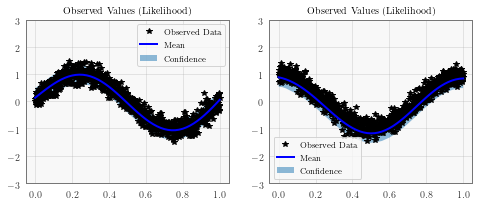

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None